# Experiments: Utility-based Adaptive Teaching Strategies using Bayesian Theory of Mind
## Utility of the Bayesian ToM-teachers

In this notebook, we evaluate the utility over multiple trials of the ToM-teachers compared with baselines teachers.

In [1]:
from __future__ import annotations
import warnings

import sys
sys.path.append('../')

from minigrid.core.actions import Actions
from minigrid.core.constants import IDX_TO_COLOR, DIR_TO_VEC

import numpy as np
import pickle
import csv
from matplotlib import patches
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import progressbar
import pandas as pd
import scipy.stats as stats

from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
from PIL import Image

from environment import MultiGoalsEnv, MultiRoomsGoalsEnv 
from learner import BayesianLearner
from bayesian_ToM.bayesian_teacher import AlignedBayesianTeacher, BayesianTeacher
from tools.utils import *
from tools.utils_viz import *

warnings.filterwarnings("ignore", category=RuntimeWarning)

pygame 2.4.0 (SDL 2.26.4, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Parameters

GRID_SIZE = 11
GRID_SIZE_DEMO = 33

num_colors = 4

rf_values_basic = [3, 5]
rf_values = np.array(rf_values_basic + [GRID_SIZE])
rf_values_demo = np.array(rf_values_basic + [GRID_SIZE_DEMO])

num_rf = len(rf_values)
num_rf_demo = len(rf_values_demo)

### Statistics on the utility of the teachers - Rationality Principle based / Aligned

In [3]:
print(f'MultiGoalsEnv observation nvironment: \n \
      GRID_SIZE {GRID_SIZE}\n \
      (max_steps={GRID_SIZE ** 2}) \n')

print(f'MultiRoomsGoalsEnv demonstration environment: \n \
      GRID_SIZE {GRID_SIZE_DEMO}\n \
      (max_steps={GRID_SIZE_DEMO ** 2 // 2}) \n')

lambd = 0.01

print(f'Teacher: \n \
      Boltzmann temperatire lambda={lambd}')


MultiGoalsEnv observation nvironment: 
       GRID_SIZE 11
       (max_steps=121) 

MultiRoomsGoalsEnv demonstration environment: 
       GRID_SIZE 33
       (max_steps=544) 

Teacher: 
       Boltzmann temperatire lambda=0.01


#### Teaching cost

In [4]:
alpha = 0.8
def cost_fun(x: int, l: int) -> float:
    return alpha * (x / l)

N = 100

#### Maximal numer of observations of the learner accessible to the teacher

In [5]:
max_obs = GRID_SIZE ** 2

#### Trials run

In [22]:
if max_obs == GRID_SIZE ** 2:
    save_filename = f'./outputs/eval_utility/obs_{GRID_SIZE}_demo_{GRID_SIZE_DEMO}_norm_linear_{alpha}_N_{N}.pickle'
else:
    save_filename = f'./outputs/eval_utility/obs_{GRID_SIZE}_demo_{GRID_SIZE_DEMO}_norm_linear_{alpha}_N_{N}_max_obs_{max_obs}.pickle'

DICT_UTIL = {}
DICT_UTIL[lambd] = {}
DICT_UTIL['omniscient'] = {}
DICT_UTIL['aligned'] = {}
DICT_UTIL['utility_opt_non_adaptive'] = {}
DICT_UTIL['reward_opt_non_adaptive'] = {}
DICT_UTIL['uniform_sampling'] = {}
DICT_UTIL['uniform_model'] = {}

for rf_idx, receptive_field in enumerate(rf_values):
    for goal_color in range(num_colors):

        DICT_UTIL[lambd][goal_color, receptive_field] = []
        DICT_UTIL['aligned'][goal_color, receptive_field] = []
        DICT_UTIL['omniscient'][goal_color, receptive_field] = []
        DICT_UTIL['utility_opt_non_adaptive'][goal_color, receptive_field] = []
        DICT_UTIL['reward_opt_non_adaptive'][goal_color, receptive_field] = []
        DICT_UTIL['uniform_sampling'][goal_color, receptive_field] = []
        DICT_UTIL['uniform_model'][goal_color, receptive_field] = []

        for _ in trange(N):
            # print(f'Learner: rf={receptive_field} goal_color={IDX_TO_COLOR[goal_color+1]}')
            # Test teacher utility
            learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE, env_type='MultiGoalsEnv')
            teacher = BayesianTeacher(env=learner.env, lambd=lambd, rf_values=rf_values_basic)
            aligned_teacher = AlignedBayesianTeacher(env=learner.env, rf_values=rf_values_basic)

            # Teacher observes the learner during one full episode on the first simple env
            ii = 0
            learner_pos_list = []
            learner_dir_list = []
            learner_action_list = []
            while not learner.terminated and ii < max_obs:
                
                agent_pos = learner.env.agent_pos
                learner_pos_list.append(agent_pos)

                agent_dir = learner.env.agent_dir
                learner_dir_list.append(agent_dir)

                teacher.update_knowledge(learner_pos=agent_pos, learner_dir=agent_dir, learner_step_count=ii)
                aligned_teacher.update_knowledge(learner_pos=agent_pos, learner_dir=agent_dir, learner_step_count=ii)

                traj = learner.play(size=1)
                learner_action_list.append(traj[0])

                teacher.observe(action=traj[0])
                aligned_teacher.observe(action=traj[0])

                ii += 1

            # Teacher use ToM to predict the utility of each demo for this particular learner --> select the more relevant demo
            learner = BayesianLearner(goal_color=goal_color, receptive_field=rf_values_demo[rf_idx], \
                                      grid_size=GRID_SIZE_DEMO, env_type='MultiRoomsGoalsEnv')
            aligned_teacher.init_env(learner.env)
            teacher.init_env(learner.env)
            
            # Compute all the demonstrations
            all_demos = []
            l_max = 0
            # Random demos
            for n_obj in range(3, 9):
                demo = generate_random_demo(learner.env, n_obj=n_obj)
                all_demos.append(demo)
                l_max = np.max([len(demo), l_max])
            # Learner-specific demos
            for gc in range(num_colors):
                 for rf in rf_values_demo[:-1]:
                      demo = generate_demo(learner.env, rf, gc)
                      all_demos.append(demo)
                      l_max = np.max([len(demo), l_max])
            all_demos.append([]) # Full obs

            ## Rationality principle teacher
            selected_demo, demo_idx, predicted_best_utility, demos = teacher.select_demo(l_max, cost_fun, all_demos)

            # Learner "observes" the demo
            learner.observe(selected_demo)

            # Reset step count in the env
            learner.env.step_count = 0
            # Learner play after seen the demo
            _ = learner.play()

            utility = learner.reward - cost_fun(len(selected_demo), l_max)

            DICT_UTIL[lambd][goal_color, receptive_field].append(utility)
        
            ## Utility map        
            true_utility = np.zeros((num_colors, len(rf_values_demo), len(all_demos)))
            true_reward = np.zeros((num_colors, len(rf_values_demo), len(all_demos)))

            for gc in range(num_colors):
                 for ii, rf in enumerate(rf_values_demo):
                    for jj, demo in enumerate(all_demos):
                        reward = aligned_teacher.predicted_reward(demo, gc, ii)

                        true_reward[gc, ii, jj] = reward
                        true_utility[gc, ii, jj] = reward - cost_fun(len(demo), l_max)

            ## Aligned teacher
            weighted_utility = true_utility.copy()
            for gc in range(num_colors):
                for ii in range(num_rf_demo):
                    weighted_utility[gc, ii, :] *= aligned_teacher.beliefs[gc, ii]
            selected_demo_idx = np.argmax(weighted_utility.sum(axis=0).sum(axis=0))

            utility = true_utility[goal_color, rf_idx, selected_demo_idx]
            DICT_UTIL['aligned'][goal_color, receptive_field].append(utility)

            ## Omnicient teacher
            selected_demo_idx = np.argmax(true_utility[goal_color, rf_idx, :])

            utility = true_utility[goal_color, rf_idx, selected_demo_idx]
            DICT_UTIL['omniscient'][goal_color, receptive_field].append(utility)
            
            ## Utility optimal non-adaptive but goal omniscient
            mean_util_per_demo = true_utility.mean(axis=0).mean(axis=0)
            selected_demo_idx = np.argmax(mean_util_per_demo)

            utility = true_utility[goal_color, rf_idx, selected_demo_idx]
            DICT_UTIL['utility_opt_non_adaptive'][goal_color, receptive_field].append(utility)

            ## Reward optimal non-adaptive but goal omniscient
            mean_reward_per_demo = true_reward.mean(axis=0).mean(axis=0)
            selected_demo_idx = np.argmax(mean_reward_per_demo)

            utility = true_utility[goal_color, rf_idx, selected_demo_idx]
            DICT_UTIL['reward_opt_non_adaptive'][goal_color, receptive_field].append(utility)

            ## Uniform sample
            selected_demo_idx = np.random.randint(0, len(all_demos))

            utility = true_utility[goal_color, rf_idx, selected_demo_idx]
            DICT_UTIL['uniform_sampling'][goal_color, receptive_field].append(utility)

            ## Uniform model
            pred_goal = np.random.randint(0, num_colors)
            pred_rf_idx = np.random.randint(0, len(rf_values))
            pred_rf = rf_values_demo[pred_rf_idx]

            selected_demo_idx = np.argmax(true_utility[pred_goal, pred_rf_idx, :])

            utility = true_utility[goal_color, rf_idx, selected_demo_idx]
            DICT_UTIL['uniform_model'][goal_color, receptive_field].append(utility)

with open(save_filename, 'wb') as f:
        pickle.dump(DICT_UTIL, f)

100%|██████████| 100/100 [4:19:01<00:00, 155.41s/it] 


## Display results

In [14]:
# Parameters

GRID_SIZE = 11
GRID_SIZE_DEMO = 33

num_colors = 4

rf_values_basic = [3, 5]
rf_values = np.array(rf_values_basic + [GRID_SIZE])
rf_values_demo = np.array(rf_values_basic + [GRID_SIZE_DEMO])

num_rf = len(rf_values)
num_rf_demo = len(rf_values_demo)

lambd = 0.01

alpha = 0.6

N = 100

max_obs = 10 #GRID_SIZE ** 2

In [15]:
if max_obs == GRID_SIZE ** 2:
    load_filename = f'../outputs/eval_utility/obs_{GRID_SIZE}_demo_{GRID_SIZE_DEMO}_norm_linear_{alpha}_{N}.pickle'
else:
    load_filename = f'../outputs/eval_utility/obs_{GRID_SIZE}_demo_{GRID_SIZE_DEMO}_norm_linear_{alpha}_{N}_{max_obs}.pickle'

with open(load_filename, 'rb') as f:    
    DICT_UTIL = pickle.load(f)

p-value =  0.634597696259694
p-value =  0.1606428368704078
p-value =  5.301509108229924e-10


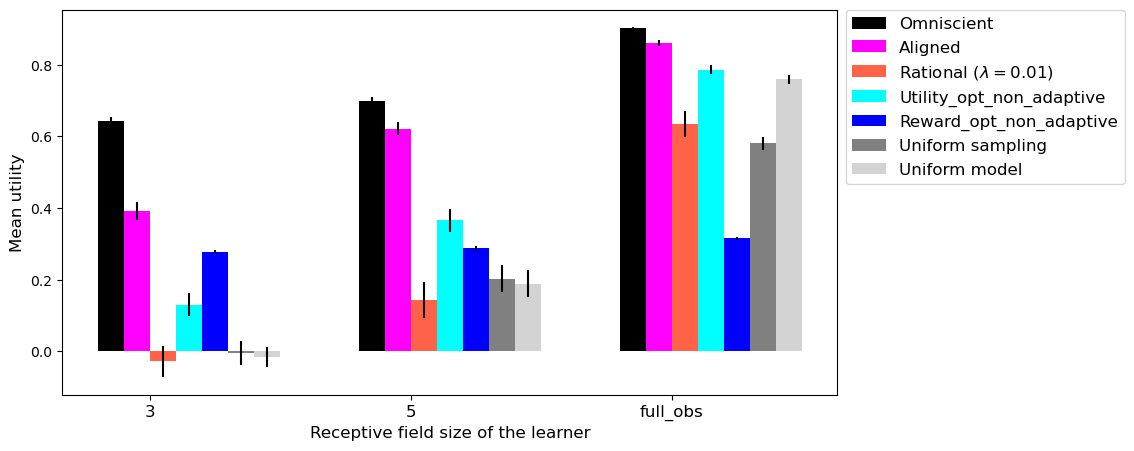

In [17]:
bayesien_all_utility_mean = []
aligned_all_utility_mean = []
omniscient_all_utility_mean = []
utility_opt_non_adaptive_all_utility_mean = []
reward_opt_non_adaptive_all_utility_mean = []
uniform_sampling_all_utility_mean = []
uniform_model_all_utility_mean = []

bayesien_all_utility_std = []
aligned_all_utility_std = []
omniscient_all_utility_std = []
utility_opt_non_adaptive_all_utility_std = []
reward_opt_non_adaptive_all_utility_std = []
uniform_sampling_all_utility_std = []
uniform_model_all_utility_std = []

for rf_idx,receptive_field in enumerate(rf_values):
    bayesien_all_utility = []
    aligned_all_utility = []

    omniscient_all_utility = []
    utility_opt_non_adaptive_all_utility = []
    reward_opt_non_adaptive_all_utility = []
    uniform_model_all_utility = []
    uniform_sampling_all_utility = []

    for goal_color in range(num_colors):
        
        bayesien_all_utility += list(np.array(DICT_UTIL[lambd][goal_color, receptive_field]))
        
        aligned_all_utility += list(np.array(DICT_UTIL['aligned'][goal_color, receptive_field]))

        # Baselines
        omniscient_all_utility += list(np.array(DICT_UTIL['omniscient'][goal_color, receptive_field]))

        utility_opt_non_adaptive_all_utility += list(np.array(DICT_UTIL['utility_opt_non_adaptive'][goal_color, receptive_field]))
        reward_opt_non_adaptive_all_utility += list(np.array(DICT_UTIL['reward_opt_non_adaptive'][goal_color, receptive_field]))
        
        uniform_sampling_all_utility += list(np.array(DICT_UTIL['uniform_sampling'][goal_color, receptive_field]))
        uniform_model_all_utility += list(np.array(DICT_UTIL['uniform_model'][goal_color, receptive_field]))

    
    bayesien_all_utility_mean.append(np.mean(bayesien_all_utility))
    aligned_all_utility_mean.append(np.mean(aligned_all_utility))

    omniscient_all_utility_mean.append(np.mean(omniscient_all_utility))
    utility_opt_non_adaptive_all_utility_mean.append(np.mean(utility_opt_non_adaptive_all_utility))
    reward_opt_non_adaptive_all_utility_mean.append(np.mean(reward_opt_non_adaptive_all_utility))
    uniform_sampling_all_utility_mean.append(np.mean(uniform_sampling_all_utility))
    uniform_model_all_utility_mean.append(np.mean(uniform_model_all_utility))

    bayesien_all_utility_std.append(np.std(bayesien_all_utility))
    aligned_all_utility_std.append(np.std(aligned_all_utility))

    omniscient_all_utility_std.append(np.std(omniscient_all_utility))
    utility_opt_non_adaptive_all_utility_std.append(np.std(utility_opt_non_adaptive_all_utility))
    reward_opt_non_adaptive_all_utility_std.append(np.std(reward_opt_non_adaptive_all_utility))
    uniform_sampling_all_utility_std.append(np.std(uniform_sampling_all_utility))
    uniform_model_all_utility_std.append(np.std(uniform_model_all_utility))

    ## Student T-test to assess that two teachers select demonstrations with significantly different utilities in average
    t_statistic, p_value = stats.ttest_ind(uniform_model_all_utility, bayesien_all_utility)

    print('p-value = ', p_value)


fig = plt.figure(figsize=(10, 5))
colors = [np.array([149, 183, 226]) / 255, 'blue', np.array([52, 85, 156]) / 255, 'yellowgreen']

# plt.title(f'Utility')

bar_width = 0.1
x_pos = np.arange(len(np.array(rf_values_basic + ['full_obs']).astype(str)))

plt.bar(x_pos, omniscient_all_utility_mean, width=bar_width, align='center', yerr=1.96 * np.array(omniscient_all_utility_std) / np.sqrt(len(omniscient_all_utility)), color=['k']*4, label=f'Omniscient')

plt.bar(x_pos + bar_width, aligned_all_utility_mean, width=bar_width, align='center', yerr=1.96 * np.array(aligned_all_utility_std) / np.sqrt(len(aligned_all_utility)), color=['fuchsia']*4, label=f'Aligned')
plt.bar(x_pos + 2 * bar_width, bayesien_all_utility_mean, width=bar_width, align='center', yerr=1.96 * np.array(bayesien_all_utility_std) / np.sqrt(len(bayesien_all_utility)), color=['tomato']*4, label=f'Rational ($\lambda={lambd}$)')

plt.bar(x_pos + 3 * bar_width, utility_opt_non_adaptive_all_utility_mean, width=bar_width, align='center', yerr=1.96 * np.array(utility_opt_non_adaptive_all_utility_std) / np.sqrt(len(utility_opt_non_adaptive_all_utility)), color=['cyan']*4, label=f'Utility_opt_non_adaptive')
plt.bar(x_pos + 4 * bar_width, reward_opt_non_adaptive_all_utility_mean, width=bar_width, align='center', yerr=1.96 * np.array(reward_opt_non_adaptive_all_utility_std) / np.sqrt(len(reward_opt_non_adaptive_all_utility)), color=['blue']*4, label=f'Reward_opt_non_adaptive')

plt.bar(x_pos + 5 * bar_width, uniform_sampling_all_utility_mean, width=bar_width, align='center', yerr=1.96 * np.array(uniform_sampling_all_utility_std) / np.sqrt(len(uniform_sampling_all_utility)), color=['gray']*4, label=f'Uniform sampling')
plt.bar(x_pos + 6 * bar_width, uniform_model_all_utility_mean, width=bar_width, align='center', yerr=1.96 * np.array(uniform_model_all_utility_std) / np.sqrt(len(uniform_model_all_utility)), color=['lightgray']*4, label=f'Uniform model')

plt.xticks(x_pos + 1.5 * bar_width, np.array(rf_values_basic + ['full_obs']).astype(str), fontsize=12)
plt.xlabel('Receptive field size of the learner', fontsize=12)
plt.ylabel('Mean utility', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02), fontsize=12);